In [1]:
import cv2
import numpy as np
import torch
from PIL import Image
from utils.transform_utils import generateTrainImagePair,get_warp_flow

/home/gaobiaoli/miniconda3/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_path="/CV/gaobiaoli/project/RegistrationNet/demo/demo.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
img,img_warp, flow, disturbed_corners,ori, H=generateTrainImagePair(image,image)

In [4]:
image=torch.tensor(image).unsqueeze(0).permute(0,3,1,2).cuda()
img=torch.tensor(img).unsqueeze(0).permute(0,3,1,2).cuda()
flow=torch.tensor(flow).unsqueeze(0).permute(0,3,1,2).cuda()

In [18]:
img2=get_warp_flow(image,flow,start=torch.tensor(ori[0]).unsqueeze(0).cuda()).squeeze(0).permute(1,2,0).cpu().numpy().astype(np.uint8)

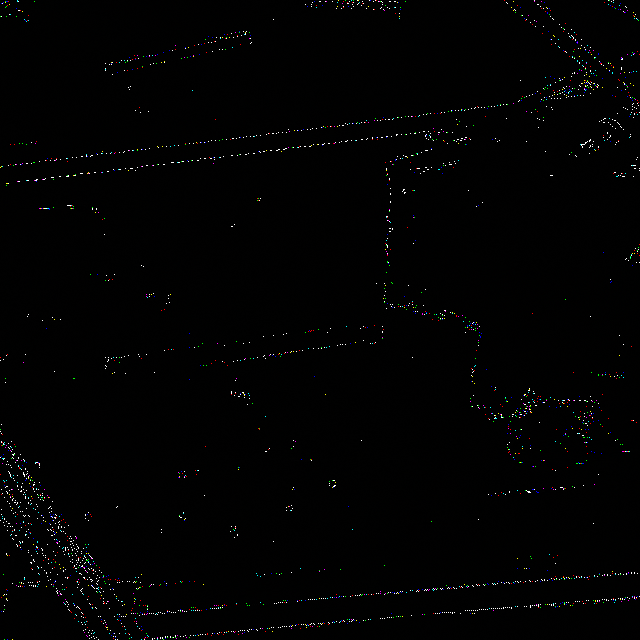

In [19]:
Image.fromarray(img_warp-img2)

In [7]:
img

tensor([[[[ 83,  68,  55,  ..., 150, 135,  30],
          [ 98,  99,  96,  ..., 116, 163, 102],
          [101, 101, 100,  ...,  58, 141, 160],
          ...,
          [115, 115, 116,  ..., 165, 163, 158],
          [117, 116, 116,  ..., 157, 153, 146],
          [121, 120, 121,  ..., 160, 154, 146]],

         [[ 47,  29,  16,  ..., 163, 148,  45],
          [ 62,  63,  57,  ..., 129, 176, 117],
          [ 67,  67,  64,  ...,  73, 156, 173],
          ...,
          [138, 138, 136,  ..., 145, 144, 140],
          [137, 136, 135,  ..., 137, 134, 128],
          [140, 139, 138,  ..., 140, 135, 128]],

         [[ 47,  30,  17,  ..., 169, 154,  50],
          [ 62,  63,  58,  ..., 135, 182, 122],
          [ 66,  66,  64,  ...,  78, 161, 179],
          ...,
          [144, 144, 143,  ..., 134, 130, 126],
          [144, 143, 142,  ..., 126, 120, 114],
          [147, 146, 146,  ..., 129, 121, 114]]]], device='cuda:0',
       dtype=torch.uint8)

In [ ]:
import torch.nn as nn
def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()

    if x.is_cuda:
        grid = grid.to(x.device)
    vgrid = torch.autograd.Variable(grid) + flo

    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :] / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :] / max(H - 1, 1) - 1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    output = nn.functional.grid_sample(x, vgrid, align_corners=True)
    mask = torch.autograd.Variable(torch.ones(x.size())).to(x.device)
    mask = nn.functional.grid_sample(mask, vgrid, align_corners=True)

    mask[mask < 0.999] = 0
    mask[mask > 0] = 1

    return output * mask
img3=warp(image.float(),flow.float()).squeeze().permute(1,2,0).cpu().numpy().astype(np.uint8)

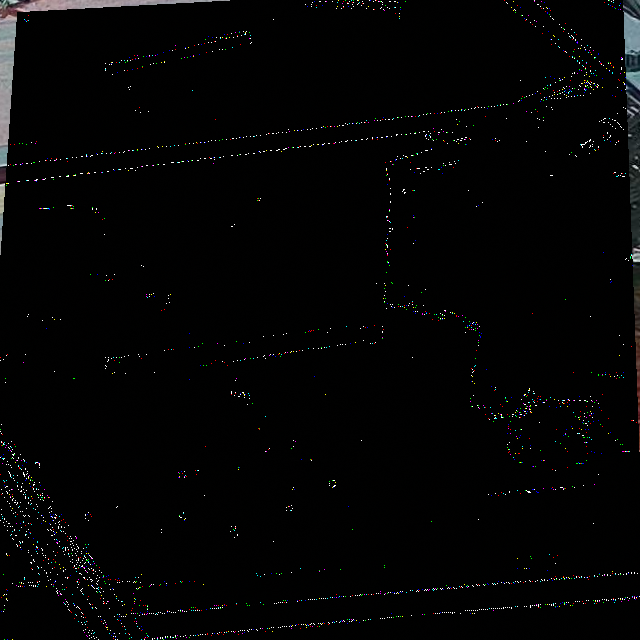

: 

In [ ]:
Image.fromarray(img_warp-img3)